# Transformação: Bronze to Silver
## Lakehouse Local com Spark

In [13]:
# Configuração do Spark para trabalhar com arquivos locais
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Lakehouse Local") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:2.2.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .getOrCreate()

In [15]:
# Caminhos locais (usando sistema de arquivos)
bronze_path = "../data/bronze/"  # Caminho relativo no container
silver_path = "../data/silver/"  # Camada Silver local

print("Caminhos configurados:")
print(f"Bronze: {bronze_path}")
print(f"Silver: {silver_path}")

Caminhos configurados:
Bronze: ../data/bronze/
Silver: ../data/silver/


## Ler dados da camada Bronze

In [4]:
# Ler dados CSV
orders_df = spark.read.option("header", "true").csv(f"{bronze_path}orders.csv")
customers_df = spark.read.option("header", "true").csv(f"{bronze_path}customers.csv")
products_df = spark.read.option("header", "true").csv(f"{bronze_path}products.csv")

print("DataFrames carregados:")
print(f"Orders: {orders_df.count()} registros")
print(f"Customers: {customers_df.count()} registros")
print(f"Products: {products_df.count()} registros")

DataFrames carregados:
Orders: 5000 registros
Customers: 200 registros
Products: 100 registros


## Mostrar esquemas e dados de exemplo

In [5]:
print("Esquema de Orders:")
orders_df.printSchema()
print("\nPrimeiras 5 linhas de Orders:")
orders_df.show(5)

print("\nEsquema de Customers:")
customers_df.printSchema()
print("\nPrimeiras 5 linhas de Customers:")
customers_df.show(5)

Esquema de Orders:
root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- order_amount: string (nullable = true)
 |-- order_date: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- payment_method: string (nullable = true)


Primeiras 5 linhas de Orders:
+--------+-----------+----------+--------+------------+-------------------+------------+--------------+
|order_id|customer_id|product_id|quantity|order_amount|         order_date|order_status|payment_method|
+--------+-----------+----------+--------+------------+-------------------+------------+--------------+
|       1|        185|        86|       7|      303.98|2025-08-30 19:07:06|   completed|        paypal|
|       2|         96|        22|       6|      563.95|2025-08-24 10:35:00|     pending|        paypal|
|       3|         28|        45|       5|      650.59|2025-08-27 22:58:38|     shi

## Transformações

In [16]:
from pyspark.sql.functions import col, to_timestamp, date_format, upper, initcap
from pyspark.sql.types import DoubleType, IntegerType

# Transformar orders
orders_transformed = orders_df \
    .withColumn("order_date", to_timestamp(col("order_date"), "yyyy-MM-dd HH:mm:ss")) \
    .withColumn("order_amount", col("order_amount").cast(DoubleType())) \
    .withColumn("quantity", col("quantity").cast(IntegerType())) \
    .withColumn("order_year", date_format(col("order_date"), "yyyy")) \
    .withColumn("order_month", date_format(col("order_date"), "MM")) \
    .withColumn("order_status", upper(col("order_status")))

# Transformar customers
customers_transformed = customers_df \
    .withColumn("customer_name", initcap(col("customer_name"))) \
    .withColumn("customer_city", initcap(col("customer_city"))) \
    .withColumn("credit_score", col("credit_score").cast(IntegerType()))

# Transformar products
products_transformed = products_df \
    .withColumn("product_price", col("product_price").cast(DoubleType())) \
    .withColumn("cost_price", col("cost_price").cast(DoubleType())) \
    .withColumn("stock_quantity", col("stock_quantity").cast(IntegerType())) \
    .withColumn("product_category", initcap(col("product_category")))

print("Transformações aplicadas!")

Transformações aplicadas!


## Criar diretório Silver se não existir

In [17]:
import os

# Criar diretório silver localmente
os.makedirs(silver_path, exist_ok=True)
print(f"Diretório Silver criado: {silver_path}")

Diretório Silver criado: ../data/silver/


## Escrever na camada Silver (Delta Lake)

In [18]:
# Escrever dados transformados
orders_transformed.write.format("delta").mode("overwrite").save(f"{silver_path}orders")
customers_transformed.write.format("delta").mode("overwrite").save(f"{silver_path}customers")
products_transformed.write.format("delta").mode("overwrite").save(f"{silver_path}products")

print("✅ Dados escritos na camada Silver com sucesso!")

Py4JJavaError: An error occurred while calling o311.save.
: java.lang.NoClassDefFoundError: org/apache/spark/sql/execution/datasources/FileFormatWriter$Empty2Null
	at org.apache.spark.sql.delta.DeltaLog.startTransaction(DeltaLog.scala:237)
	at org.apache.spark.sql.delta.DeltaLog.startTransaction(DeltaLog.scala:234)
	at org.apache.spark.sql.delta.DeltaLog.withNewTransaction(DeltaLog.scala:250)
	at org.apache.spark.sql.delta.commands.WriteIntoDelta.run(WriteIntoDelta.scala:91)
	at org.apache.spark.sql.delta.sources.DeltaDataSource.createRelation(DeltaDataSource.scala:159)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:48)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:859)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:388)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:304)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:240)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.lang.ClassNotFoundException: org.apache.spark.sql.execution.datasources.FileFormatWriter$Empty2Null
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:445)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:592)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:525)
	... 46 more


## Verificação

In [19]:
# Verificar dados escritos
silver_orders = spark.read.format("delta").load(f"{silver_path}orders")
silver_customers = spark.read.format("delta").load(f"{silver_path}customers")
silver_products = spark.read.format("delta").load(f"{silver_path}products")

print("Camada Silver:")
print(f"Orders: {silver_orders.count()} registros")
print(f"Customers: {silver_customers.count()} registros")
print(f"Products: {silver_products.count()} registros")

print("\nEsquema de Orders transformado:")
silver_orders.printSchema()

print("\nPrimeiros registros de Orders transformados:")
silver_orders.show(5)

AnalysisException: [PATH_NOT_FOUND] Path does not exist: ../data/silver/orders.

In [20]:
print("Verificando camada Silver:")

Verificando camada Silver:


In [22]:
print("Verificando camada Silver:")
silver_files = os.listdir('../data/silver/')
print("Arquivos em silver:", silver_files)


Verificando camada Silver:
Arquivos em silver: []


In [23]:
spark.stop()


In [24]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Lakehouse Local") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:2.4.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .getOrCreate()

print("✅ Spark configurado com Delta Lake 2.4.0 (compatível com Spark 3.5.0)")


✅ Spark configurado com Delta Lake 2.4.0 (compatível com Spark 3.5.0)


In [27]:
orders_df = spark.read.option("header", "true").csv(f"{bronze_path}orders.csv")

In [28]:
customers_df = spark.read.option("header", "true").csv(f"{bronze_path}customers.csv")

In [29]:
products_df = spark.read.option("header", "true").csv(f"{bronze_path}products.csv")

In [30]:
print("DataFrames carregados:")


DataFrames carregados:


In [31]:
print(f"Orders: {orders_df.count()} registros")

Orders: 5000 registros


In [32]:
print(f"Customers: {customers_df.count()} registros")

Customers: 200 registros


In [33]:
print(f"Products: {products_df.count()} registros")

Products: 100 registros


In [34]:
from pyspark.sql.functions import col, to_timestamp, date_format, upper, initcap
from pyspark.sql.types import DoubleType, IntegerType

# Transformar orders
orders_transformed = orders_df \
    .withColumn("order_date", to_timestamp(col("order_date"), "yyyy-MM-dd HH:mm:ss")) \
    .withColumn("order_amount", col("order_amount").cast(DoubleType())) \
    .withColumn("quantity", col("quantity").cast(IntegerType())) \
    .withColumn("order_year", date_format(col("order_date"), "yyyy")) \
    .withColumn("order_month", date_format(col("order_date"), "MM")) \
    .withColumn("order_status", upper(col("order_status")))

# Transformar customers
customers_transformed = customers_df \
    .withColumn("customer_name", initcap(col("customer_name"))) \
    .withColumn("customer_city", initcap(col("customer_city"))) \
    .withColumn("credit_score", col("credit_score").cast(IntegerType()))

# Transformar products
products_transformed = products_df \
    .withColumn("product_price", col("product_price").cast(DoubleType())) \
    .withColumn("cost_price", col("cost_price").cast(DoubleType())) \
    .withColumn("stock_quantity", col("stock_quantity").cast(IntegerType())) \
    .withColumn("product_category", initcap(col("product_category")))

print("✅ Transformações aplicadas!")

✅ Transformações aplicadas!


In [35]:
import os

# Criar diretório silver localmente
os.makedirs(silver_path, exist_ok=True)
print(f"✅ Diretório Silver criado: {silver_path}")

✅ Diretório Silver criado: ../data/silver/


In [36]:
orders_transformed.write.format("delta").mode("overwrite").save(f"{silver_path}orders")
customers_transformed.write.format("delta").mode("overwrite").save(f"{silver_path}customers")
products_transformed.write.format("delta").mode("overwrite").save(f"{silver_path}products")

print("✅ Dados escritos na camada Silver com sucesso! (Formato Delta Lake)")

Py4JJavaError: An error occurred while calling o456.save.
: java.lang.NoClassDefFoundError: org/apache/spark/sql/execution/datasources/FileFormatWriter$Empty2Null
	at org.apache.spark.sql.delta.DeltaLog.startTransaction(DeltaLog.scala:237)
	at org.apache.spark.sql.delta.DeltaLog.startTransaction(DeltaLog.scala:234)
	at org.apache.spark.sql.delta.DeltaLog.withNewTransaction(DeltaLog.scala:250)
	at org.apache.spark.sql.delta.commands.WriteIntoDelta.run(WriteIntoDelta.scala:91)
	at org.apache.spark.sql.delta.sources.DeltaDataSource.createRelation(DeltaDataSource.scala:159)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:48)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:859)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:388)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:304)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:240)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.lang.ClassNotFoundException: org.apache.spark.sql.execution.datasources.FileFormatWriter$Empty2Null
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:445)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:592)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:525)
	... 46 more


In [37]:
spark.stop()

In [38]:
from pyspark.sql import SparkSession

# Configurar Spark sem Delta Lake (apenas Parquet)
spark = SparkSession.builder \
    .appName("Lakehouse Local - Parquet") \
    .getOrCreate()

print("✅ Spark configurado para usar Parquet!")

✅ Spark configurado para usar Parquet!


In [39]:
orders_df = spark.read.option("header", "true").csv(f"{bronze_path}orders.csv")
customers_df = spark.read.option("header", "true").csv(f"{bronze_path}customers.csv")
products_df = spark.read.option("header", "true").csv(f"{bronze_path}products.csv")

print("DataFrames carregados:")
print(f"Orders: {orders_df.count()} registros")
print(f"Customers: {customers_df.count()} registros")
print(f"Products: {products_df.count()} registros")

DataFrames carregados:
Orders: 5000 registros
Customers: 200 registros
Products: 100 registros


In [40]:
from pyspark.sql.functions import col, to_timestamp, date_format, upper, initcap
from pyspark.sql.types import DoubleType, IntegerType

# Transformar orders
orders_transformed = orders_df \
    .withColumn("order_date", to_timestamp(col("order_date"), "yyyy-MM-dd HH:mm:ss")) \
    .withColumn("order_amount", col("order_amount").cast(DoubleType())) \
    .withColumn("quantity", col("quantity").cast(IntegerType())) \
    .withColumn("order_year", date_format(col("order_date"), "yyyy")) \
    .withColumn("order_month", date_format(col("order_date"), "MM")) \
    .withColumn("order_status", upper(col("order_status")))

# Transformar customers
customers_transformed = customers_df \
    .withColumn("customer_name", initcap(col("customer_name"))) \
    .withColumn("customer_city", initcap(col("customer_city"))) \
    .withColumn("credit_score", col("credit_score").cast(IntegerType()))

# Transformar products
products_transformed = products_df \
    .withColumn("product_price", col("product_price").cast(DoubleType())) \
    .withColumn("cost_price", col("cost_price").cast(DoubleType())) \
    .withColumn("stock_quantity", col("stock_quantity").cast(IntegerType())) \
    .withColumn("product_category", initcap(col("product_category")))

print("✅ Transformações aplicadas!")

✅ Transformações aplicadas!


In [41]:
# Escrever dados transformados na camada Silver (FORMATO PARQUET)
orders_transformed.write.format("parquet").mode("overwrite").save(f"{silver_path}orders")
customers_transformed.write.format("parquet").mode("overwrite").save(f"{silver_path}customers")
products_transformed.write.format("parquet").mode("overwrite").save(f"{silver_path}products")

print("✅ Dados escritos na camada Silver com sucesso! (Formato Parquet)")

✅ Dados escritos na camada Silver com sucesso! (Formato Parquet)


In [42]:
silver_orders = spark.read.parquet(f"{silver_path}orders")
silver_customers = spark.read.parquet(f"{silver_path}customers")
silver_products = spark.read.parquet(f"{silver_path}products")

print("Camada Silver (Parquet):")
print(f"Orders: {silver_orders.count()} registros")
print(f"Customers: {silver_customers.count()} registros")
print(f"Products: {silver_products.count()} registros")

print("\nEsquema de Orders transformado:")
silver_orders.printSchema()

print("\nPrimeiros registros de Orders transformados:")
silver_orders.show(5)

Camada Silver (Parquet):
Orders: 5000 registros
Customers: 200 registros
Products: 100 registros

Esquema de Orders transformado:
root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- order_amount: double (nullable = true)
 |-- order_date: timestamp (nullable = true)
 |-- order_status: string (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- order_year: string (nullable = true)
 |-- order_month: string (nullable = true)


Primeiros registros de Orders transformados:
+--------+-----------+----------+--------+------------+-------------------+------------+--------------+----------+-----------+
|order_id|customer_id|product_id|quantity|order_amount|         order_date|order_status|payment_method|order_year|order_month|
+--------+-----------+----------+--------+------------+-------------------+------------+--------------+----------+-----------+
|      

In [43]:
import os

# Verificar estrutura de arquivos
print("Estrutura de pastas:")
print("Conteúdo de data:", os.listdir('../data/'))
print("Conteúdo de silver:", os.listdir('../data/silver/'))
print("Conteúdo de orders:", os.listdir('../data/silver/orders/'))

Estrutura de pastas:
Conteúdo de data: ['bronze', 'silver']
Conteúdo de silver: ['orders', 'customers', 'products']
Conteúdo de orders: ['.part-00000-28a90400-2350-4e9e-ae16-8b7ae97f5961-c000.snappy.parquet.crc', '._SUCCESS.crc', '_SUCCESS', 'part-00000-28a90400-2350-4e9e-ae16-8b7ae97f5961-c000.snappy.parquet']


In [44]:
from pyspark.sql.functions import sum, count, avg

# Exemplo: Vendas por cliente
sales_by_customer = silver_orders.groupBy("customer_id").agg(
    sum("order_amount").alias("total_spent"),
    count("order_id").alias("total_orders"),
    avg("order_amount").alias("avg_order_value")
)

sales_by_customer.write.format("parquet").mode("overwrite").save("../data/gold/sales_by_customer")

In [45]:
# Converter para Pandas para visualização
sales_pd = sales_by_customer.toPandas()
print(sales_pd.head(10))

  customer_id  total_spent  total_orders  avg_order_value
0         125     15450.97            29       532.792069
1           7     16390.98            30       546.366000
2         124     13277.43            27       491.756667
3          51     13884.28            24       578.511667
4         169     10283.65            17       604.920588
5          54     16874.88            30       562.496000
6          15     15289.68            25       611.587200
7         155     11149.74            25       445.989600
8         154     14428.34            22       655.833636
9         132     12978.53            27       480.686296


In [46]:
# Conteúdo do notebook 02_silver_to_gold.ipynb
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, count, avg, max, min, countDistinct, when, col
import os

# Configurar Spark
spark = SparkSession.builder \
    .appName("Silver to Gold Transformations") \
    .getOrCreate()

# Caminhos
silver_path = "/home/jovyan/data/silver/"
gold_path = "/home/jovyan/data/gold/"

# Garantir que diretório gold existe
os.makedirs(gold_path, exist_ok=True)

In [47]:
# Ler dados Silver
orders_silver = spark.read.parquet(f"{silver_path}orders")
customers_silver = spark.read.parquet(f"{silver_path}customers")

# Vendas por cliente
sales_by_customer = orders_silver \
    .groupBy("customer_id") \
    .agg(
        sum("order_amount").alias("total_gasto"),
        count("order_id").alias("total_pedidos"),
        avg("order_amount").alias("valor_medio_pedido"),
        max("order_amount").alias("maior_valor_pedido"),
        min("order_date").alias("primeira_compra"),
        max("order_date").alias("ultima_compra")
    )

# Salvar
sales_by_customer.write.format("parquet").mode("overwrite").save(f"{gold_path}vendas_por_cliente")

In [48]:
products_silver = spark.read.parquet(f"{silver_path}products")

sales_by_category = orders_silver \
    .join(products_silver, "product_id") \
    .groupBy("product_category") \
    .agg(
        sum("order_amount").alias("faturamento_total"),
        sum("quantity").alias("unidades_vendidas"),
        countDistinct("order_id").alias("pedidos_unicos"),
        avg("order_amount").alias("ticket_medio")
    ) \
    .orderBy(col("faturamento_total").desc())

sales_by_category.write.format("parquet").mode("overwrite").save(f"{gold_path}vendas_por_categoria")

In [49]:
customer_360 = customers_silver \
    .join(sales_by_customer, "customer_id", "left") \
    .withColumn("segmento_cliente", 
               when(col("total_gasto") > 5000, "VIP")
               .when(col("total_gasto") > 2000, "Premium")
               .otherwise("Standard")) \
    .withColumn("frequencia_compra", 
               when(col("total_pedidos") > 10, "Alta")
               .when(col("total_pedidos") > 5, "Média")
               .otherwise("Baixa"))

customer_360.write.format("parquet").mode("overwrite").save(f"{gold_path}customer_360")

In [50]:
# No Jupyter, executar:
!pip install matplotlib seaborn plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.3/407.3 kB 4.4 MB/s eta 0:00:00:00:01


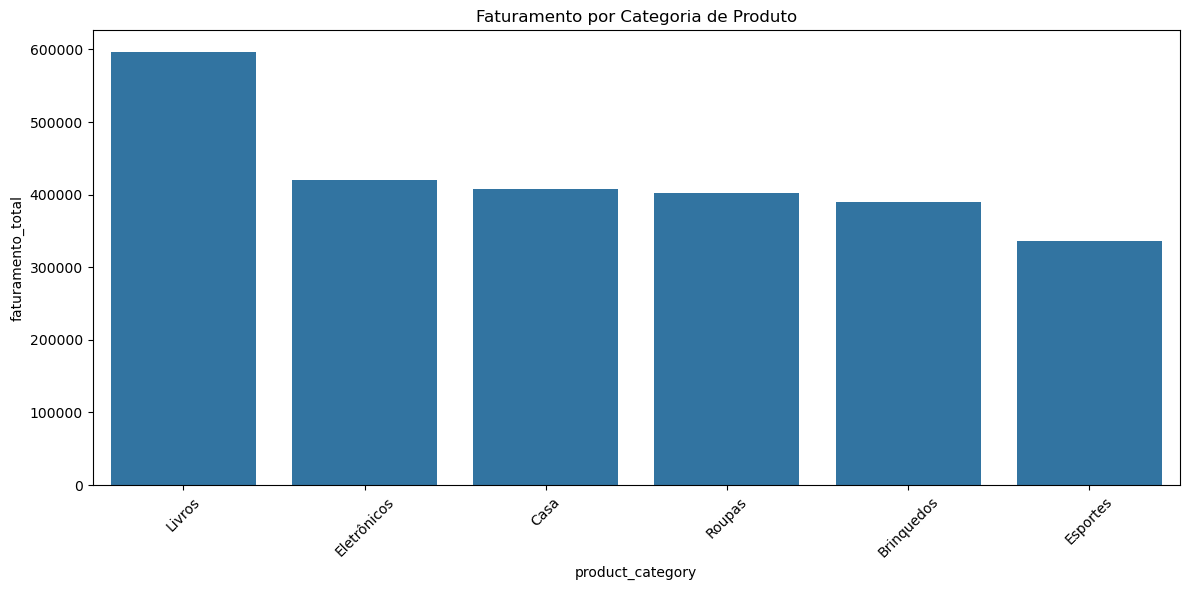

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Converter para Pandas para visualização
sales_category_pd = sales_by_category.toPandas()

# Gráfico de faturamento por categoria
plt.figure(figsize=(12, 6))
sns.barplot(x='product_category', y='faturamento_total', data=sales_category_pd)
plt.title('Faturamento por Categoria de Produto')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [52]:
# Criar arquivo ~/lakehouse-local/dags/lakehouse_dag.py
from airflow import DAG
from airflow.operators.bash_operator import BashOperator
from datetime import datetime, timedelta

default_args = {
    'owner': 'tercio',
    'depends_on_past': False,
    'start_date': datetime(2024, 9, 20),
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=5),
}

dag = DAG(
    'lakehouse_pipeline',
    default_args=default_args,
    description='Pipeline completo do Lakehouse',
    schedule_interval=timedelta(days=1),
)

# Tasks
generate_data = BashOperator(
    task_id='gerar_dados',
    bash_command='cd /home/jovyan/scripts && python data_generator.py',
    dag=dag,
)

bronze_to_silver = BashOperator(
    task_id='bronze_para_silver',
    bash_command='cd /home/jovyan/work && python -m nbconvert --execute 01_bronze_to_silver.ipynb',
    dag=dag,
)

silver_to_gold = BashOperator(
    task_id='silver_para_gold',
    bash_command='cd /home/jovyan/work && python -m nbconvert --execute 02_silver_to_gold.ipynb',
    dag=dag,
)

# Ordem de execução
generate_data >> bronze_to_silver >> silver_to_gold

ModuleNotFoundError: No module named 'airflow'

In [53]:
# Criar arquivo ~/lakehouse-local/dags/lakehouse_dag.py
from airflow import DAG
from airflow.operators.bash_operator import BashOperator
from datetime import datetime, timedelta

default_args = {
    'owner': 'tercio',
    'depends_on_past': False,
    'start_date': datetime(2024, 9, 20),
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=5),
}

dag = DAG(
    'lakehouse_pipeline',
    default_args=default_args,
    description='Pipeline completo do Lakehouse',
    schedule_interval=timedelta(days=1),
)

# Tasks
generate_data = BashOperator(
    task_id='gerar_dados',
    bash_command='cd /home/jovyan/scripts && python data_generator.py',
    dag=dag,
)

bronze_to_silver = BashOperator(
    task_id='bronze_para_silver',
    bash_command='cd /home/jovyan/work && python -m nbconvert --execute 01_bronze_to_silver.ipynb',
    dag=dag,
)

silver_to_gold = BashOperator(
    task_id='silver_para_gold',
    bash_command='cd /home/jovyan/work && python -m nbconvert --execute 02_silver_to_gold.ipynb',
    dag=dag,
)

# Ordem de execução
generate_data >> bronze_to_silver >> silver_to_gold

ModuleNotFoundError: No module named 'airflow'